In [1]:
import sys; sys.path.append('../src')
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
BATCH_SIZE = 10
EPOCHS = 100
SEED = 2

In [12]:
from discocat_aux import read_data

train_labels, train_data = read_data('../Datasets/mc_train_data.txt')
val_labels, val_data = read_data('../Datasets/mc_test_data.txt')
test_labels, test_data = read_data('../Datasets/mc_test_data.txt')

In [19]:
print('{}\t{}\n'.format(train_data[0], train_labels[0]))
print('{}\t{}'.format(train_data[4], train_labels[4]))

skillful man prepares sauce .	[1, 0]

skillful woman debugs program .	[0, 1]


In [14]:
from lambeq import BobcatParser

parser = BobcatParser(root_cats=('S', 'N'), verbose='text')
raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [20]:
print('{}\n'.format(raw_train_diagrams[0]))
print('{}'.format(raw_train_diagrams[4]))

skillful >> n @ n.l @ man >> n @ n.l @ n @ prepares >> n @ n.l @ n @ n.r @ s @ n.l @ sauce >> n @ Cup(n.l, n) @ n.r @ s @ n.l @ n >> n @ n.r @ s @ Cup(n.l, n) >> Cup(n, n.r) @ s

skillful >> n @ n.l @ woman >> n @ n.l @ n @ n.l @ debugs >> n @ n.l @ n @ n.l @ n @ n.l @ program >> n @ n.l @ n @ n.l @ n @ Cup(n.l, n) >> n @ n.l @ n @ Cup(n.l, n) >> n @ Cup(n.l, n)


In [21]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
val_diagrams = [remove_cups(diagram) for diagram in raw_val_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

In [22]:
print(train_diagrams[0])

man >> n @ prepares >> n @ n.r @ s @ sauce.l >> skillful.r @ s


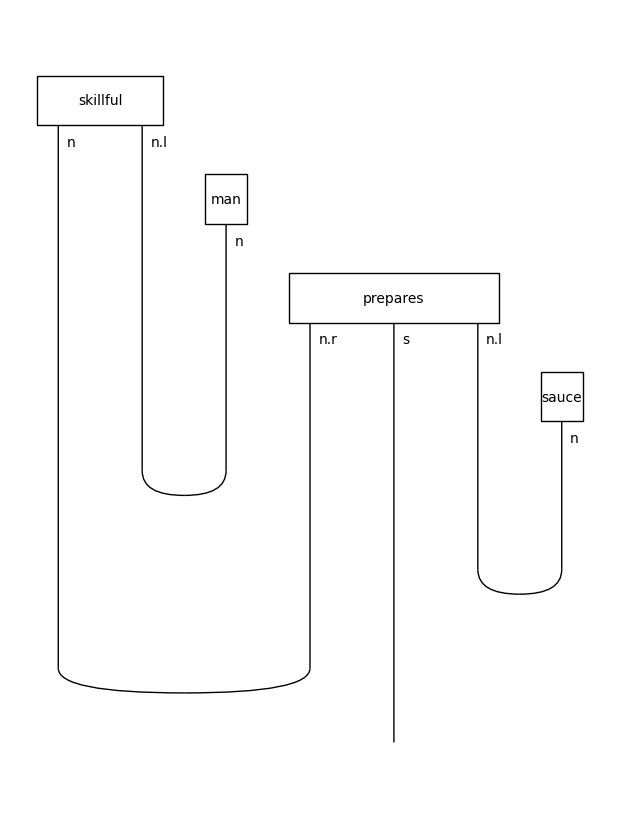

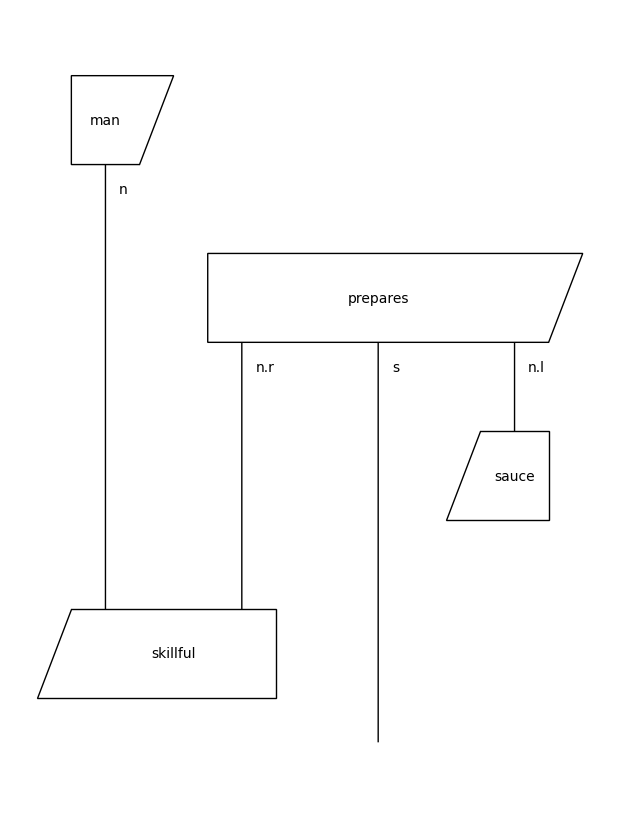

In [36]:
raw_train_diagrams[0].draw(figsize=(6,8))
train_diagrams[0].draw(figsize=(6,8))

In [26]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=2, n_single_qubit_params=3)

raw_train_circuits = [ansatz(diagram) for diagram in raw_train_diagrams]
raw_val_circuits =  [ansatz(diagram) for diagram in raw_val_diagrams]
raw_test_circuits = [ansatz(diagram) for diagram in raw_test_diagrams]

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
val_circuits =  [ansatz(diagram) for diagram in val_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

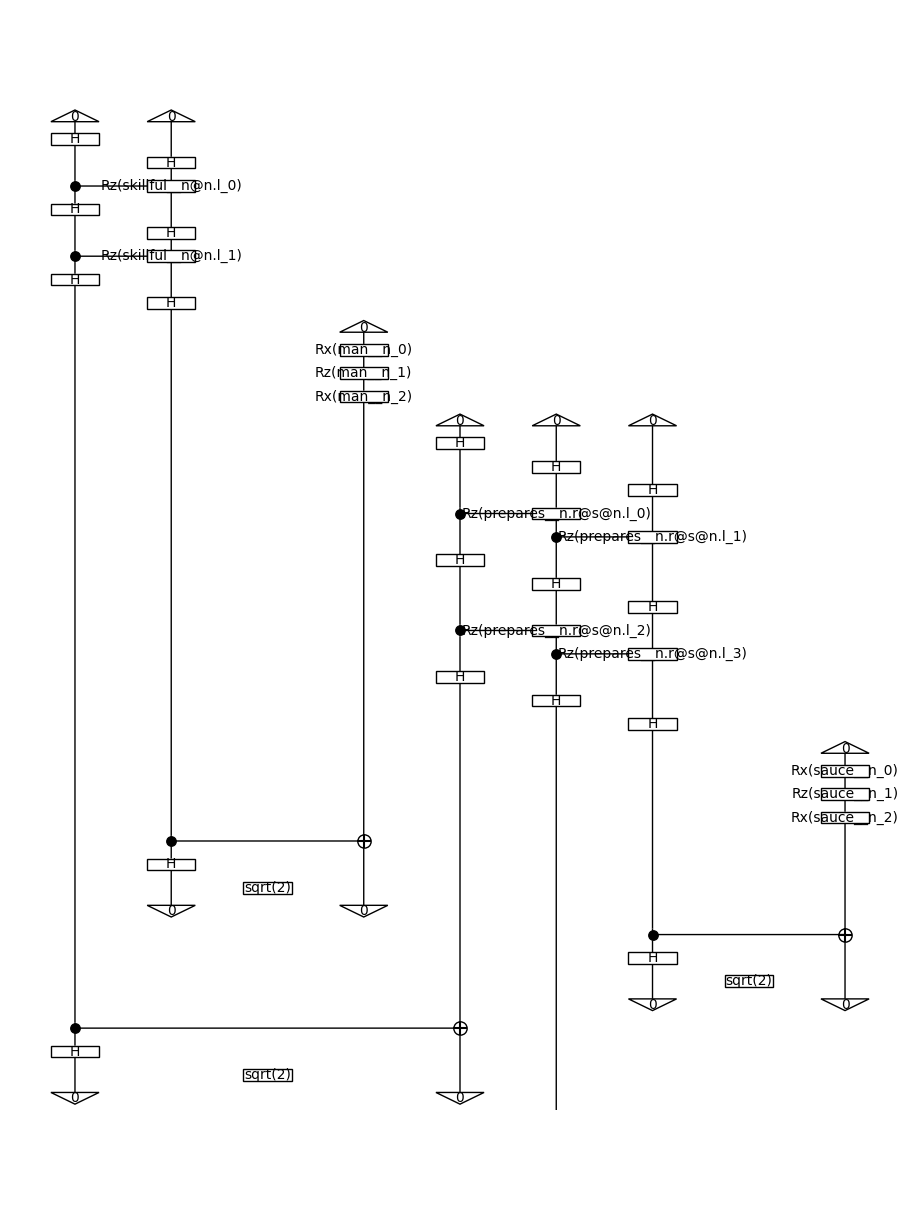

In [27]:
raw_train_circuits[0].draw(figsize=(9, 12))

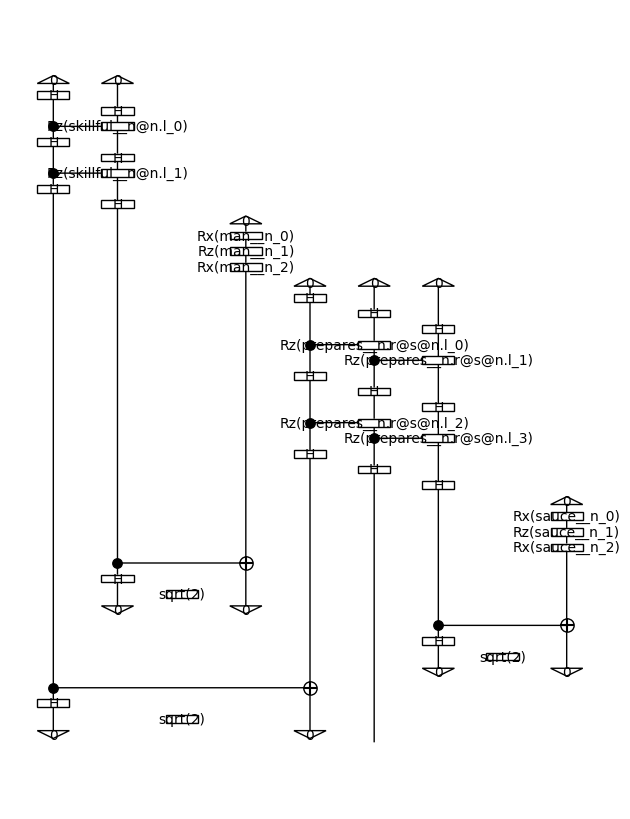

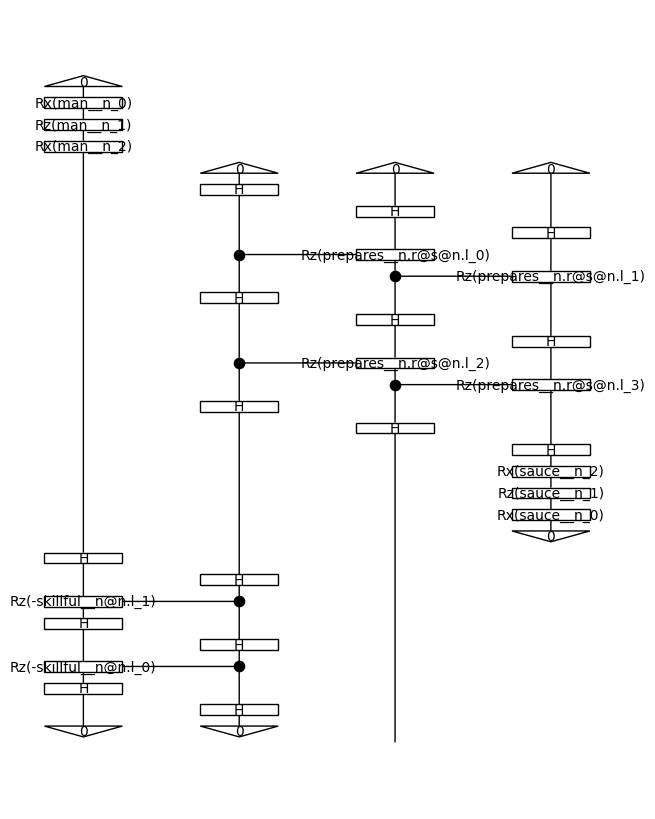

In [33]:
raw_train_circuits[0].draw(figsize=(6, 8))
train_circuits[0].draw(figsize=(6, 8))

In [39]:
from discocat_models import DisCoCatClassifier
from pytket.extensions.qiskit import AerBackend

all_circuits = train_circuits + val_circuits + test_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

model = DisCoCatClassifier.from_diagrams(all_circuits, backend_config=backend_config)

In [40]:
from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
# bce = BinaryCrossEntropyLoss()
bce = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}

In [41]:
from lambeq import QuantumTrainer, SPSAOptimizer, PytorchTrainer

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [42]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

In [43]:
trainer.fit(train_dataset, val_dataset, log_interval=10)

Epoch 10:   train/loss: 0.6205   valid/loss: 0.6242   train/acc: 0.6571   valid/acc: 0.5333
Epoch 20:   train/loss: 0.5513   valid/loss: 0.6801   train/acc: 0.7429   valid/acc: 0.5000
Epoch 30:   train/loss: 0.4584   valid/loss: 0.6043   train/acc: 0.8143   valid/acc: 0.6667
Epoch 40:   train/loss: 0.4093   valid/loss: 0.4011   train/acc: 0.8857   valid/acc: 0.8333
Epoch 50:   train/loss: 0.3007   valid/loss: 0.3548   train/acc: 0.7857   valid/acc: 0.8333
Epoch 60:   train/loss: 0.2273   valid/loss: 0.3141   train/acc: 0.8714   valid/acc: 0.8667
Epoch 70:   train/loss: 0.2169   valid/loss: 0.2889   train/acc: 0.8857   valid/acc: 0.8667
Epoch 80:   train/loss: 0.2498   valid/loss: 0.3186   train/acc: 0.8714   valid/acc: 0.8667
Epoch 90:   train/loss: 0.2352   valid/loss: 0.2955   train/acc: 0.9143   valid/acc: 0.8667
Epoch 100:  train/loss: 0.3947   valid/loss: 0.2837   train/acc: 0.9143   valid/acc: 0.8667

Training completed!


Test accuracy: 0.8666666666666667


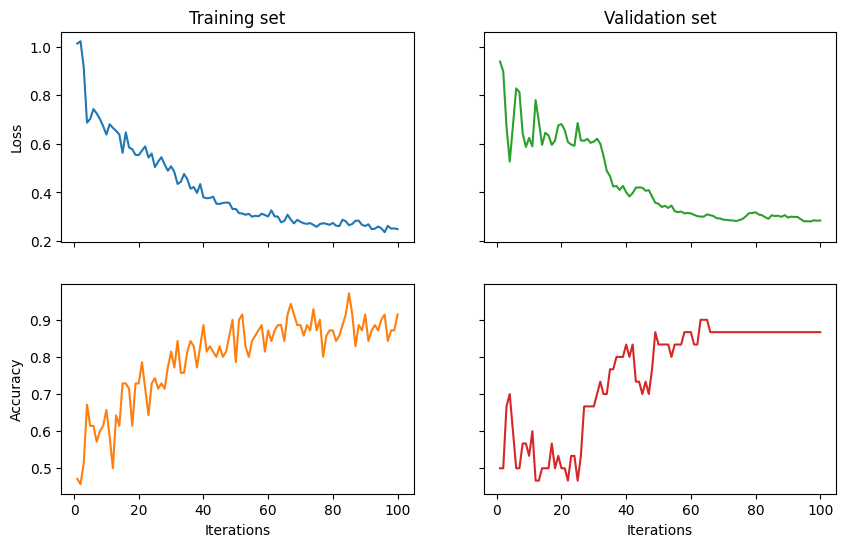

In [18]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Validation set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc)

In [99]:
import torch
import torch.nn as nn

import pennylane as qml

class DisCoCat(nn.Module):
    def __init__(self, backend):
        super(DisCoCat, self).__init__()

In [102]:
import torch.nn as nn
import torch.nn.functional as F

# from discocat import DisCoCat

class DisCoCatClassifier(nn.Module):
    def __init__(self, backend='default.qubit'):
        super(DisCoCatClassifier, self).__init__()
        
        self.dcc = DisCoCat(backend=backend)

    def forward(self, sentence):

        
        
        dcc_out = self.dcc(sentence)
        tag_logits = self.hidden2tag(dcc_out[-1])
        tag_scores = F.softmax(tag_logits, dim=1)

        return tag_scores

In [48]:
import pennylane as qml

In [57]:
qasm_qc = 'OPENQASM 2.0;'\
'include "qelib1.inc";'\
'qreg q[4];'\
'creg c[4];'\
'h q[0];'\
'h q[1];'\
'h q[2];'\
'h q[3];'\
'rx(-5.83575439453125) q[0];'\
'rx(3.0817887783050537) q[1];'\
'rx(6.2831854820251465) q[2];'\
'rx(-2.703190803527832) q[3];'\
'ry(4.3862385749816895) q[0];'\
'ry(-2.796048879623413) q[1];'\
'ry(4.547079563140869) q[2];'\
'ry(0.24207083880901337) q[3];'\
'rx(0.008736874908208847) q[0];'\
'rx(0.0478125661611557) q[1];'\
'rx(1.1719969511032104) q[2];'\
'rx(3.225823402404785) q[3];'\
'rzz(pi/2) q[0],q[1];'\
'rzz(pi/2) q[2],q[3];'\
'rx(3.926330804824829) q[1];'\
'rx(-7.0732550621032715) q[2];'\
'ry(3.5824084281921387) q[1];'\
'ry(-4.642556190490723) q[2];'\
'rx(4.258274078369141) q[1];'\
'rx(4.445951461791992) q[2];'\
'rzz(pi/2) q[1],q[2];'\
'rx(-5.83575439453125) q[0];'\
'rx(3.0817887783050537) q[1];'\
'rx(6.2831854820251465) q[2];'\
'rx(-2.703190803527832) q[3];'\
'ry(4.3862385749816895) q[0];'\
'ry(-2.796048879623413) q[1];'\
'ry(4.547079563140869) q[2];'\
'ry(0.24207083880901337) q[3];'\
'rx(4.0349955558776855) q[0];'\
'rx(5.6931610107421875) q[1];'\
'rx(2.1282923221588135) q[2];'\
'rx(1.9117591381072998) q[3];'\
'rzz(pi/2) q[0],q[1];'\
'rzz(pi/2) q[2],q[3];'\
'rx(3.926330804824829) q[1];'\
'rx(-7.0732550621032715) q[2];'\
'ry(3.5824084281921387) q[1];'\
'ry(-4.642556190490723) q[2];'\
'rx(5.65288782119751) q[1];'\
'rx(5.604392051696777) q[2];'\
'rzz(pi/2) q[1],q[2];'\
'u3(6.148791790008545,1.9398895502090454,1.4527209997177124) q[0];'\
'u3(1.696185827255249,3.791520118713379,0.8488606214523315) q[1];'\
'u3(2.986509323120117,5.9026198387146,5.418046951293945) q[2];'\
'u3(2.0095486640930176,2.0094242095947266,1.867727279663086) q[3];'

In [58]:
qml_qc = qml.from_qasm(qasm_qc)

In [60]:
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def circuit():
    qml_qc(wires=(0, 1, 2, 3))
    return qml.probs(wires=[0, 1, 2, 3])

In [96]:
states = ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111',\
          '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
print(states)
results = circuit()
print(results.numpy())
for i in range(len(states[0])):
    sum = 0
    for j, p in enumerate(results.numpy()):
        if states[j][i] == '0': sum += p
        if states[j][i] == '1': sum -= p
    print(sum)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
[0.03588459 0.11654913 0.06207912 0.01510105 0.02169357 0.03232004
 0.14424549 0.32513485 0.00065    0.01156889 0.02903772 0.0205374
 0.02570432 0.02266144 0.05012912 0.08670326]
0.5060157042826895
-0.41718417304058775
-0.46593602998532857
-0.2611521438079171
